# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scripts.util import *
from scripts.builders import *

## Atributos

Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - ¿Tiene el mail contenido HTML?
    - ¿Tiene el mail imágenes?
2. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
3. Cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece (TF-IDF).
4. Análisis de sentimiento.

Para los atributos 2 y 3, se utilizó TfIdfVectorizer de scikit-learn.

El análisis de sentimientos, se extrajo de cada oración (de cada cuerpo) los valores de negatividad, neutralidad y positividad resultantes de la herramienta Vader de NLTK y se calculó la media para estos.


Un primer análisis sobre la utilización de estos atributos resaltó un tiempo de ejecución alto en la extracción de información sobre sentimientos. Mediante los experimentos realizados en el notebook (qué notebook), concluímos en que este atributo, en conjunto con los demás, no parece realizar un gran aporte a los resultados de la clasificación.

La decisión de removerlo del conjunto de experimentos posteriores implicó un grado mayor de libertad para experimentar con los diferentes atributos de los clasificadores.

## Reducción de dimensionalidad

Probaremos usando tres técnicas de selección de atributos:
    1. Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    2. Entrenar un clasificador SVM lineal con penalización L1(fuerza esparcidad, gran cantidad de pesos en 0), 
        y elegir los 2 atributos que mas importancia tengan
    3. Análisis de Componentes Principales para reducción de dimensionalidad

## Modelos

Los algoritmos de aprendizaje automático elegidos fueron los siguientes:
- Árboles de decisiones
- Bosques aleatorios (Random forests)
- Bernoulli Naive Bayes
- Naive Bayes
    - Bernoulli
    - Multinomial
- K vecinos más cercanos (KNN)
- Máquinas de vectores de soporte (SVM)

### Pre-selección y exerimentación previa

Los primeros experimentos que realizamos sobre los clasificadores arrojaron diversos resultados. Encontramos que algunos algoritmos consumían una gran parte del tiempo de ejecución, dificultando la experimentación, y que otros no conseguían buenos resultados.

Realizamos pruebas (notebook sanidad) con 10 mil elementos como muestra para poder remover los algoritmos que no obtenían una buena performance, tanto en runtime como en exactitud. 

(Podemos hablar más sobre sanidad, qué probamos, cómo lo hicimos, por qué)

De esta experimentación resultó lo siguiente:
- SVM, KNN y Naive Bayes multinomial obtuvieron la menor exactitud en la clasificación de mails (<0.7).
- SVM es costoso en tiempos de ejecución (a comparación del resto).
- KNN necesita mucha memoria RAM para su parelización, la experimentación sobre 10-Fold CV es muy costosa temporalmente.

Tomamos la decisión de remover SVM, KNN y Naive Bayes multinomial de la lista de posibles modelos para centrarnos en la experimentación de los restantes con la totalidad de las muestras de prueba.


## Experimentación sobre los modelos

### Carga de datos

Se separa inicialmente un conjunto de entrenamiento y de test, con el objetivo de poder brindar información sobre el rendimiento del clasificador elegido como el mejor para la tarea. El conjunto de test corresponde al 20% de todo el dataset.

Todos los mails son parseados utilizando el módulo email de Python.

Los mails que contienen código HTML son también parseados, utilizando el módulo HTMLParser, para la remoción del código HTML, dejando sólo el texto.

In [3]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 2.038934s

Loading Test Set
Done in 0.501019s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


### Experimentación sobre modelos

Con el objetivo de analizar el comportamiento de los diferentes modelos, se construye uno para cada una de las siguientes variaciones:
- Se realiza (o no) la extracción los atributos simples
- Se incluye (o no) la matriz (TF-IDF) del sujeto
- Se incluye (o no) la matriz (TF-IDF) del cuerpo
- Tipo de clasificador (DT, RF, NBB)

Para los atributos TF-IDF tanto del sujeto como del cuerpo, se varía sobre la utilización de los algoritmos K Best, SVM lineal con penalización L1 y PCA para la reducción de dimensionalidad de los mismos.

Para cada uno de los modelos armados (con todas las variaciones mencionadas), corremos un 10-Fold CV sobre el conjunto de entrenamiento, obteniendo la media y la varianza de los resultados del CV (exactitud), y el tiempo requerido para correrlo.

- Borrar al carajo el output de evaluate_and_meassure (measure va con una s). Si es lo suficientemente relevante (porque es necesario conocer exactitud en los números, usar tabla de pandas). Los gráficos deberían ser lo suficientemente significativos para entender los resultados.
#### Explicar parámetros de TfiIdf, por qué esos valores?
#### Explicar parámetros base de los clasificadores, por qué esos valores?


In [4]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)

In [ ]:
scores, cv_times = evaluate_and_meassure(train_set, pipelines, 'full', cv=10, n_jobs=5)

### TODO: Visualizaciones (usando DataFrame?) de los resultados, tanto puntajes de CV como runtimes

In [6]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]

    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [7]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

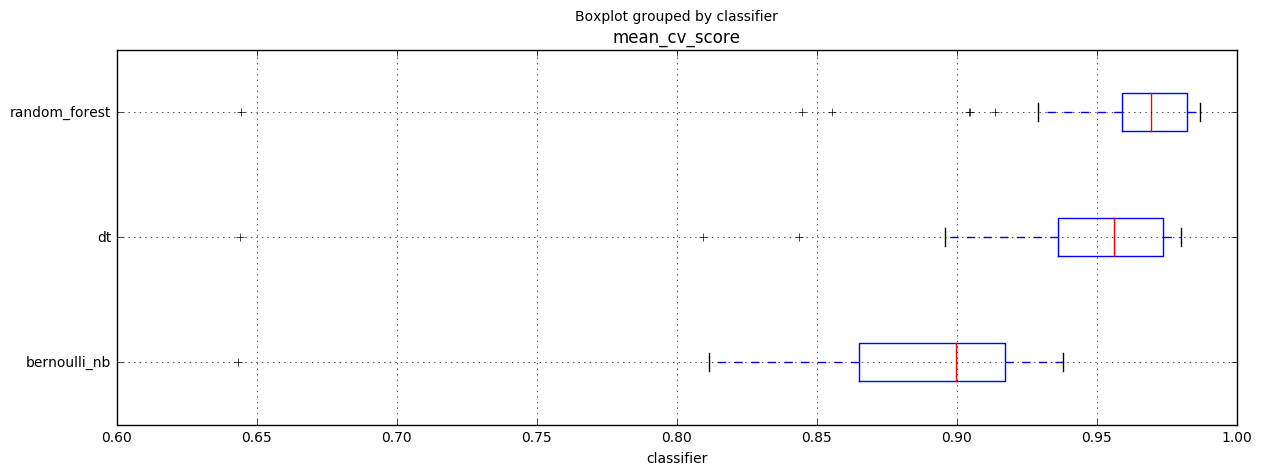

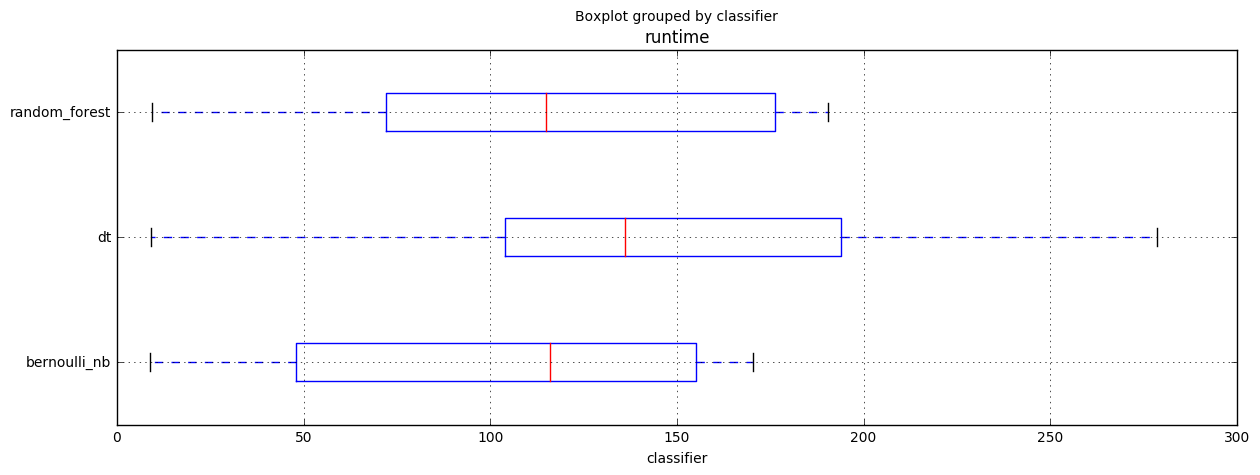

In [8]:
summary_df.boxplot(column=['mean_cv_score'], by='classifier', vert=False)
summary_df.boxplot(column=['runtime'], by='classifier', vert=False)

## Búsqueda y evaluación del mejor modelo

Para la elección del mejor modelo, calculamos la media de los valores de la exactitud reportados por cada clasificador.

Con el objetivo de simular el comportamiento del modelo elegido sobre nuevos datos, utilizamos el conjunto de testing para realizar una evaluación del modelo mediante Cross Validation.

In [9]:
mean_scores_list = [(name, np.mean(model_scores)) for name, model_scores in scores.iteritems()]
mean_scores_list[np.argmax(map(lambda x: x[1], mean_scores_list))]

('simple_features__subject_tfidf__body_l1__random_forest', 0.98698605694497932)

El modelo con mayor exactitud fue utilizando el algoritmo de clasificación de Bosques Aleatorios (RF) con:
- Atributo TF-IDF para el sujeto (aplicación simple sobre el sujeto)
- Atributo TF-IDF para el cuerpo, con reducción de dimencionalidad aplicando SVM con penalización L1.
- El conjunto de atributos simples descripto anteriormente.

Este modelo obtuvo una exactitud media de 0.986986 en la experimentación con CV. A continuación, veremos cómo se desempeña con el conjunto de testing.

In [10]:
names, best_model_name, best_model = build_pipeline(True, 'tfidf', 'l1', 'random_forest')

In [11]:
def model_evaluation(pipeline, name, X_train, X_test):
    print 'Training pipeline %s in the train set' % name
    print_time(lambda: pipeline.fit(X_train, X_train.label))
    print ''
    
    print 'Classifying test set with pipeline %s' % name
    pred = print_time(lambda: pipeline.predict(X_test))
    print ''

    print 'Accuracy: %f' % accuracy_score(X_test.label, pred)
    print ''
    
    print 'Classification report:'
    print classification_report(X_test.label, pred, target_names=['ham', 'spam'])
    print 'Confusion matrix:'
    print pd.crosstab(X_test.label, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
model_evaluation(best_model, best_model_name, train_set, test_set)

Podemos notar que la exactitud obtenida (0.987889) es levemente superior a la obtenida sobre los datos de entrenamiento (0.986986).

Guardamos este modelo para utilizarlo posteriormente en un programa separado

In [ ]:
print 'Training pipeline %s in the full dataset' % best_model_name
_ = print_time(lambda: best_model.fit(train_set.append(test_set), train_set.append(test_set).label))

In [15]:
save_model('best_model', 'results', best_model)

Saving model best_model to disk
Done in 4.240996s
Saved at results/best_model.pkl


## Exploración de atributos mas importantes

Continuamos con un análisis sobre las features encontradas. Para esto consideramos los atributos extraídos en el pipeline correspondiente al modelo elegido, podemos acceder a las de cada extractor usando named_steps.

Una vez que tenemos los features podemos quedarnos con las que resultan más significativas para nuestro clasificador usando feature_importance de random forest, lo que esto hace es tomar en cuenta el orden relativo (altura de los nodos) de los atributos usados en los arboles de decision del bosque, a mayor altura en los arboles mayor es la importancia de dicho atributo.

In [18]:
extractors = best_model.named_steps['feature_extractors']
simple_extractors = extractors.transformer_list[0][1]
subject_extractors = extractors.transformer_list[1][1]
subject_tfidf = subject_extractors.named_steps['tfidf']
body_extractors = extractors.transformer_list[2][1]
body_tfidf = body_extractors.named_steps['tfidf']
body_l1 = body_extractors.named_steps['l1']
rf = best_model.named_steps['random_forest']

feature_names = []
feature_names += [ 'simple_features_' + name  for name in simple_extractors.get_feature_names() ]
feature_names += [ 'subject_tfidf_' + name  for name in subject_tfidf.get_feature_names() ]
feature_names += [ 'body_l1_' + name  for name in body_l1.transform([body_tfidf.get_feature_names()])[0] ]
feature_names = np.asarray(feature_names)

In [19]:
extracted = extractors.transform(train_set)

In [20]:
top_features_indexs = np.argsort(rf.feature_importances_)[::-1][0:10]
top_features_importances = rf.feature_importances_[top_features_indexs]
top_feature_names = feature_names[top_features_indexs]
top_features = pd.DataFrame(extracted[:, top_features_indexs].todense(), columns=top_feature_names)
top_features['label'] = train_set.label

A continuación graficamos la frecuencia tfidf de cada una de estas features en todos los mails de testing distinguiendo si son instancias de spam o ham e indicando su nivel de importancia.

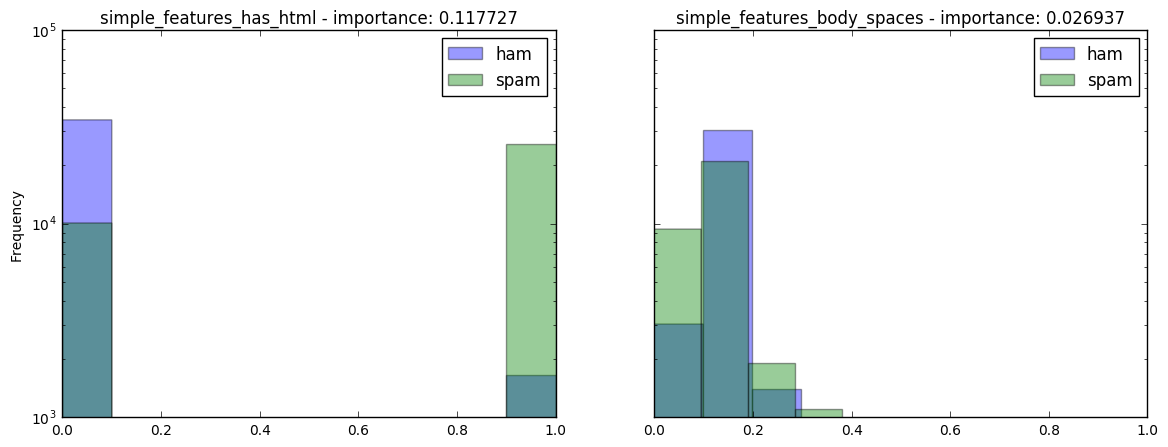

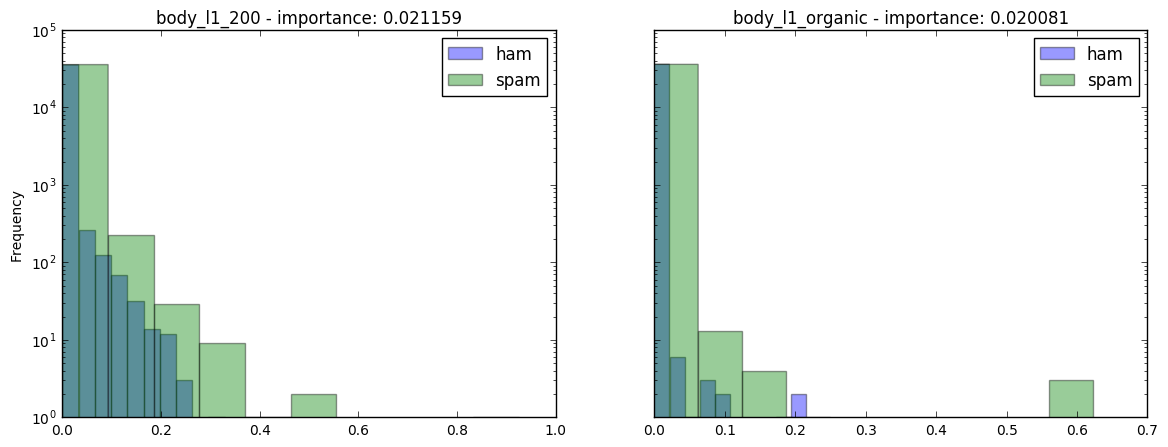

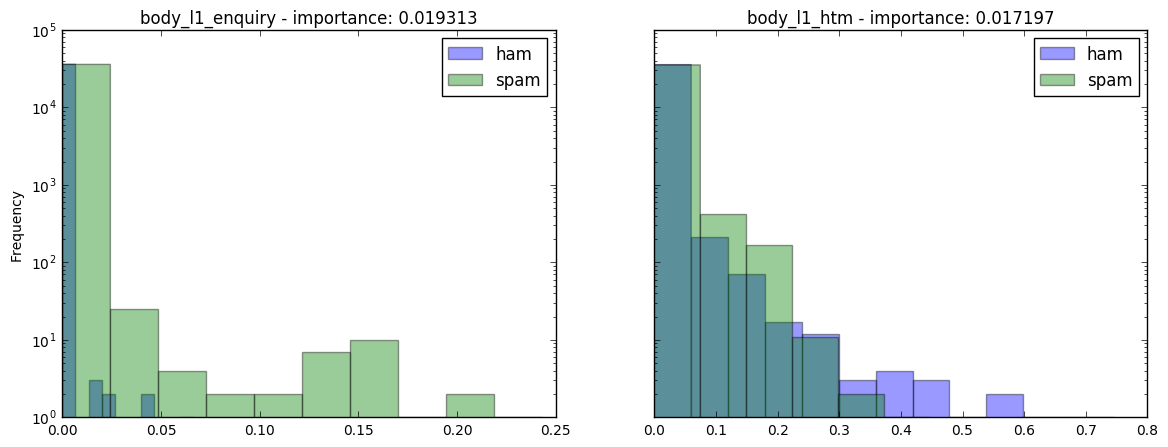

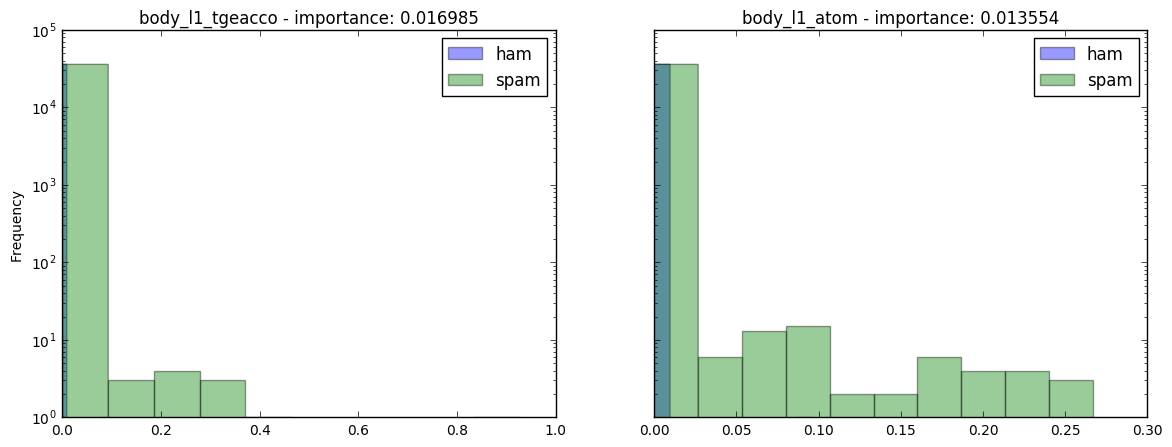

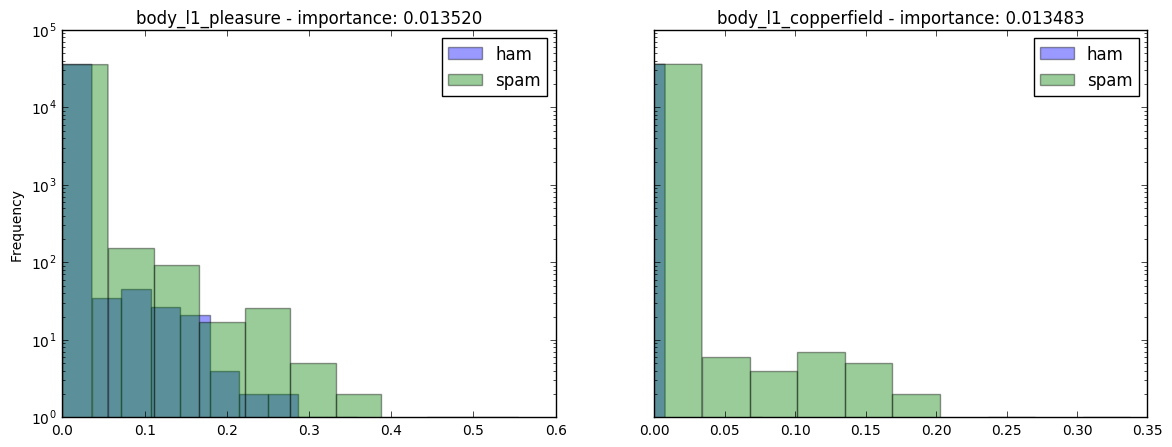

In [21]:
for i in range(10):
    if i % 2 == 0:
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    top_features.groupby('label')[top_feature_names[i]].plot(kind='hist',
                                            title=top_feature_names[i] + ' - importance: %f' % top_features_importances[i],
                                            ax=axs[i % 2],
                                            legend=True, alpha=0.4)
    

Como conclusion a este análisis, la hipótesis de la que partimos al comenzar el trabajo resultó cierta, que un mail tenga contenido HTML resulta un atributo importante al momento de clasificar spam y ham.

Este resultado da una pequeña victoria a las features implementadas a mano por sobre las miles que encontró el vectorizador, además muestra la importancia que tiene la investigación y manipulación de los datos antes de probar algoritmos ciegamente y las limitaciones que estos tienen, en este caso el algoritmo de frecuencia de terminos resulta útil para ponderar n-gramas pero se queda corto para detectar otras características del problema como la presencia de formato HTML en un mail. 

## Conclusiones

### TODO: Escribir conclusiones